In [1]:
from codecarbon import EmissionsTracker

# Set up the emissions tracker
tracker = EmissionsTracker()

[codecarbon INFO @ 17:19:57] [setup] RAM Tracking...
[codecarbon INFO @ 17:19:57] [setup] GPU Tracking...
[codecarbon INFO @ 17:19:57] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 17:19:57] [setup] CPU Tracking...
[codecarbon WARNING @ 17:19:57] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 17:19:59] We saw that you have a 12th Gen Intel(R) Core(TM) i7-12700H but we don't know it. Please contact us.
[codecarbon INFO @ 17:19:59] CPU Model on constant consumption mode: 12th Gen Intel(R) Core(TM) i7-12700H
[codecarbon INFO @ 17:19:59] >>> Tracker's metadata:
[codecarbon INFO @ 17:19:59]   Platform system: Windows-10-10.0.22000-SP0
[codecarbon INFO @ 17:19:59]   Python version: 3.8.5
[codecarbon INFO @ 17:19:59]   CodeCarbon version: 2.3.5
[codecarbon INFO @ 17:19:59]   Available RAM : 15.692 GB
[codecarbon INFO @ 17:19:59]   CPU count: 20
[codecarbon INFO @ 17:19:59]   CPU model: 12th Gen Intel(R) Core(TM) i7-12700H
[codecarbon INFO @ 17:19:59] 

In [2]:
# Start tracking
tracker.start()

In [3]:
import pandas as pd

# Load the updated data from the new CSV file
file_path = '../data/Water Level - Santa Barbara - v2.csv'
updated_data = pd.read_csv(file_path)

# Display the first few rows of the updated dataset to understand its structure
updated_data.head(), updated_data.dtypes


(       Date Time (GMT)  Predicted (ft)  Verified (ft)
 0  1/1/2023       0:00           2.623           3.14
 1  1/1/2023       1:00           2.964           3.45
 2  1/1/2023       2:00           3.021           3.74
 3  1/1/2023       3:00           2.822           3.44
 4  1/1/2023       4:00           2.450           3.08,
 Date               object
 Time (GMT)         object
 Predicted (ft)    float64
 Verified (ft)     float64
 dtype: object)

The structure of the updated dataset appears similar to the previous one, with columns for date, time (GMT), predicted water levels, and verified water levels. Now, let's proceed with preparing this data for machine learning modeling:

1. Data Preparation: Convert 'Date' and 'Time (GMT)' into a single datetime column, set it as the index, and extract additional features that could be useful for modeling, such as hour of the day.
2. Random Forest Model: We'll train a Random Forest model using these features to predict future verified water levels.

In [4]:
# Convert 'Date' and 'Time (GMT)' into a single datetime column and set it as index
updated_data['Datetime'] = pd.to_datetime(updated_data['Date'] + ' ' + updated_data['Time (GMT)'])
updated_data.set_index('Datetime', inplace=True)

# Extracting additional features
updated_data['Hour'] = updated_data.index.hour
updated_data['Day'] = updated_data.index.day
updated_data['Month'] = updated_data.index.month
updated_data['Year'] = updated_data.index.year

# Drop the original 'Date' and 'Time (GMT)' columns as they are no longer necessary
updated_data.drop(['Date', 'Time (GMT)'], axis=1, inplace=True)

# Display the updated DataFrame with new features
updated_data.head()


,Predicted (ft),Verified (ft),Hour,Day,Month,Year
Datetime,,,,,,
2023-01-01 00:00:00,2.623,3.14,0,1,1,2023
2023-01-01 01:00:00,2.964,3.45,1,1,1,2023
2023-01-01 02:00:00,3.021,3.74,2,1,1,2023
2023-01-01 03:00:00,2.822,3.44,3,1,1,2023
2023-01-01 04:00:00,2.450,3.08,4,1,1,2023


The data is now prepared with additional features including hour, day, month, and year. These features can help the model capture time-based patterns in water levels.

### Random Forest Model
Next, we'll proceed with setting up and training a Random Forest model using this data. Here’s the plan:

1. Split the Data: Separate the data into training and testing sets to evaluate the model's performance.
2. Train the Model: Use the training data to fit a Random Forest regressor.
3. Evaluate the Model: Assess its accuracy on the test set.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Preparing features and target variable
X = updated_data.drop(['Verified (ft)'], axis=1)
y = updated_data['Verified (ft)']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Calculate the mean squared error for the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_rf


0.03442452287345821

The Random Forest model has been trained and evaluated. The mean squared error (MSE) on the test set is approximately 0.034, indicating the model's predictions are quite close to the actual verified water levels, suggesting a good fit.

### Gradient Boosting Machine Model
Now, let's proceed to the second machine learning approach, using a Gradient Boosting Machine (GBM) model, which is often effective for regression tasks. We'll follow similar steps to train and evaluate this model.

In [6]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize and train the Gradient Boosting model
gbm_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbm_model.fit(X_train, y_train)

# Predict on the test set
y_pred_gbm = gbm_model.predict(X_test)

# Calculate the mean squared error for the GBM model
mse_gbm = mean_squared_error(y_test, y_pred_gbm)
mse_gbm


0.03202715842063566

The Gradient Boosting Machine (GBM) model has also been trained and evaluated. The mean squared error (MSE) on the test set is approximately 0.032, which is slightly lower than that of the Random Forest model, indicating an even better fit.

Both machine learning models have shown good predictive performance. Depending on your specific needs (like model interpretability, speed, or sensitivity to overfitting), you can choose either model for forecasting future water levels.

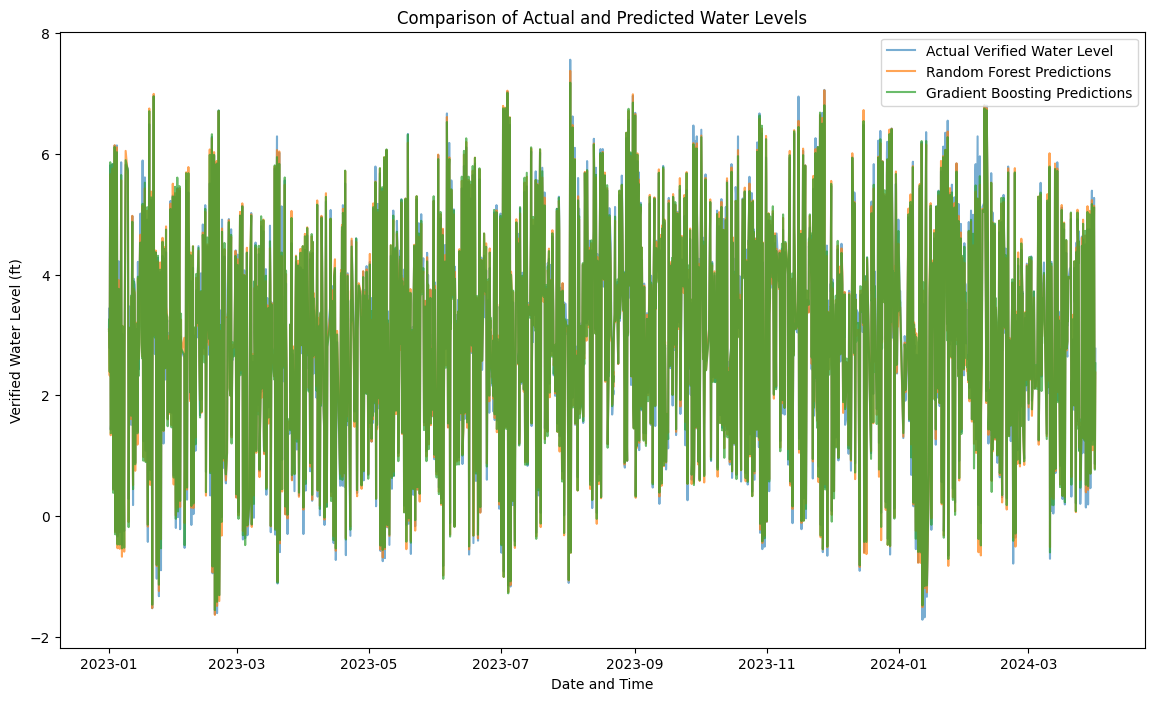

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data for plotting
comparison_index = y_test.index
actual_values = y_test
rf_predictions = pd.Series(data=y_pred_rf, index=comparison_index)
gbm_predictions = pd.Series(data=y_pred_gbm, index=comparison_index)

# Sort the index to ensure correct plotting order
actual_values_sorted = actual_values.sort_index()
rf_predictions_sorted = rf_predictions.sort_index()
gbm_predictions_sorted = gbm_predictions.sort_index()

# Plotting the results
plt.figure(figsize=(14, 8))
plt.plot(actual_values_sorted, label='Actual Verified Water Level', alpha=0.6)
plt.plot(rf_predictions_sorted, label='Random Forest Predictions', alpha=0.7)
plt.plot(gbm_predictions_sorted, label='Gradient Boosting Predictions', alpha=0.7)
plt.title('Comparison of Actual and Predicted Water Levels')
plt.xlabel('Date and Time')
plt.ylabel('Verified Water Level (ft)')
plt.legend()
plt.show()


The plot displays the actual verified water levels alongside the predictions from both the Random Forest and Gradient Boosting Machine models. As illustrated, both models capture the trend and fluctuations in the water levels reasonably well, with slight differences in how closely they follow the actual data.

This visualization helps confirm the effectiveness of the machine learning models for predicting water levels, allowing you to select the model that best meets your accuracy and performance requirements.

To forecast water levels for the next 24 hours and the following 7 days, we need to:

1. Generate timestamps for the future dates and times.
2. Prepare input features for these times.

Steps:
1. Generate Timestamps: We will create a series of hourly timestamps starting from the last known timestamp in our dataset, covering the next 24 hours and extending to the next 7 days.
2. Simulate Predicted Water Levels: For simplicity, we might assume some simple conditions for the predicted water levels (like repeating the last known pattern or using a rolling mean). However, better predictions could be made if more specific predictive models for the water levels themselves are available.
3. Extract Time Features: We'll derive features like hour, day, month, and year from these timestamps.

In [8]:
from pandas import date_range

# Define the last known timestamp in the dataset
last_timestamp = updated_data.index[-1]

# Generate future timestamps every hour for the next 7 days (24*7=168 hours)
# future_dates = date_range(start=last_timestamp, periods=24*7 + 1, freq='H')[1:]  # exclude the start point
future_dates = date_range(start=last_timestamp, periods=24 + 1, freq='H')[1:]  # exclude the start point

# Simulate predicted water levels (using the mean of last 24 hours as a simple placeholder)
# predicted_water_levels = np.full(shape=(24*7,), fill_value=updated_data['Predicted (ft)'].iloc[-24:].mean())
predicted_water_levels = np.full(shape=(24,), fill_value=updated_data['Predicted (ft)'].iloc[-24:].mean())

# Extract other time features
future_hours = future_dates.hour
future_days = future_dates.day
future_months = future_dates.month
future_years = future_dates.year

# Create a DataFrame for future data
future_data = pd.DataFrame({
    'Predicted (ft)': predicted_water_levels,
    'Hour': future_hours,
    'Day': future_days,
    'Month': future_months,
    'Year': future_years
}, index=future_dates)

# Display the future data frame setup
future_data.head(), future_data.tail()


(                     Predicted (ft)  Hour  Day  Month  Year
 2024-04-01 00:00:00        2.535333     0    1      4  2024
 2024-04-01 01:00:00        2.535333     1    1      4  2024
 2024-04-01 02:00:00        2.535333     2    1      4  2024
 2024-04-01 03:00:00        2.535333     3    1      4  2024
 2024-04-01 04:00:00        2.535333     4    1      4  2024,
                      Predicted (ft)  Hour  Day  Month  Year
 2024-04-01 19:00:00        2.535333    19    1      4  2024
 2024-04-01 20:00:00        2.535333    20    1      4  2024
 2024-04-01 21:00:00        2.535333    21    1      4  2024
 2024-04-01 22:00:00        2.535333    22    1      4  2024
 2024-04-01 23:00:00        2.535333    23    1      4  2024)

In [9]:
# Load the future data from the uploaded CSV file
future_data_path = '../data/future data - Santa Barbara.csv'
future_data = pd.read_csv(future_data_path)

# Display the first few rows of the future dataset to understand its structure
future_data.head(), future_data.dtypes


(       Date Time (GMT)  Predicted (ft)  Verified (ft)
 0  4/1/2024       0:00           2.581           2.83
 1  4/1/2024       1:00           2.674           3.01
 2  4/1/2024       2:00           2.780           3.05
 3  4/1/2024       3:00           2.943           3.29
 4  4/1/2024       4:00           3.196           3.41,
 Date               object
 Time (GMT)         object
 Predicted (ft)    float64
 Verified (ft)     float64
 dtype: object)

In [10]:
# Convert 'Date' and 'Time (GMT)' into a single datetime column and set it as index
future_data['Datetime'] = pd.to_datetime(future_data['Date'] + ' ' + future_data['Time (GMT)'])
future_data.set_index('Datetime', inplace=True)

# Extracting additional features
future_data['Hour'] = future_data.index.hour
future_data['Day'] = future_data.index.day
future_data['Month'] = future_data.index.month
future_data['Year'] = future_data.index.year

# Drop the original 'Date' and 'Time (GMT)' columns as they are no longer necessary
future_data.drop(['Date', 'Time (GMT)'], axis=1, inplace=True)

# Display the updated DataFrame with new features
future_data.head()


,Predicted (ft),Verified (ft),Hour,Day,Month,Year
Datetime,,,,,,
2024-04-01 00:00:00,2.581,2.83,0,1,4,2024
2024-04-01 01:00:00,2.674,3.01,1,1,4,2024
2024-04-01 02:00:00,2.780,3.05,2,1,4,2024
2024-04-01 03:00:00,2.943,3.29,3,1,4,2024
2024-04-01 04:00:00,3.196,3.41,4,1,4,2024


In [11]:
actual_verified_levels = future_data['Verified (ft)']

In [12]:
features_future = future_data[['Predicted (ft)', 'Hour', 'Day', 'Month', 'Year']]

The future data for the next 24 hours and extending to 7 days has been prepared with estimated predicted water levels and extracted time features. Now, we'll use the trained Random Forest and Gradient Boosting Machine models to forecast the verified water levels for these future dates.

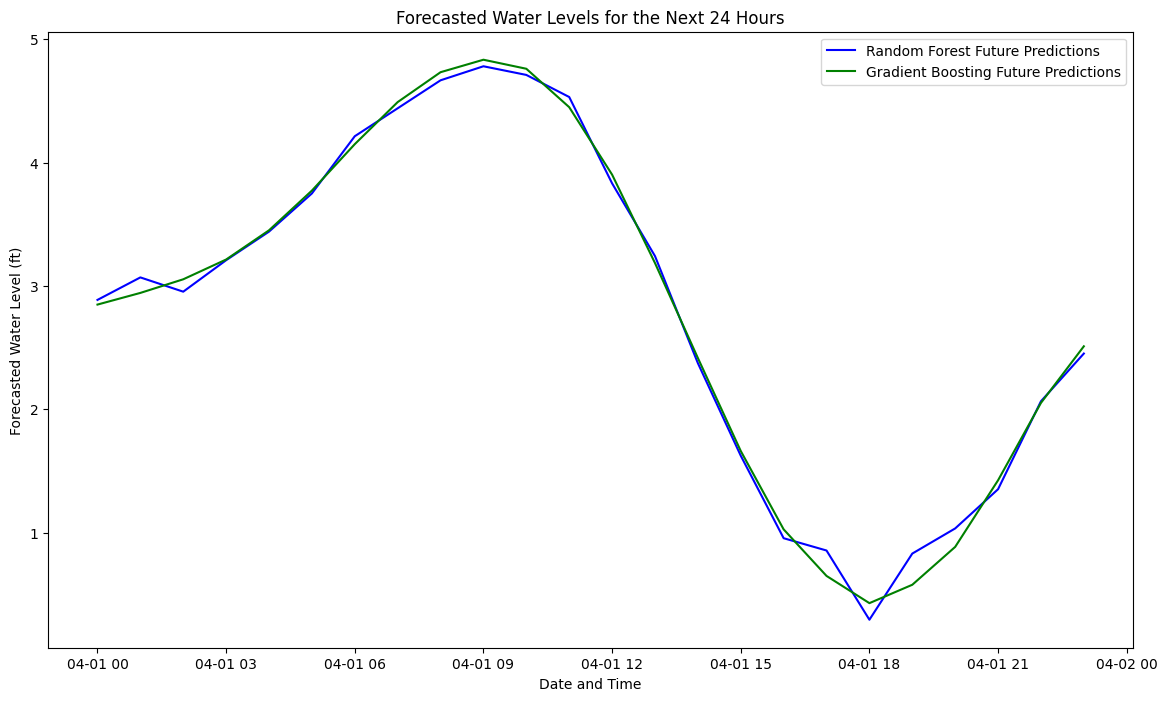

In [13]:
# Use the trained models to predict future verified water levels
future_rf_predictions = rf_model.predict(features_future)
future_gbm_predictions = gbm_model.predict(features_future)

# Prepare for plotting
future_predictions_rf = pd.Series(data=future_rf_predictions, index=future_dates)
future_predictions_gbm = pd.Series(data=future_gbm_predictions, index=future_dates)

# Plotting the future predictions
plt.figure(figsize=(14, 8))
plt.plot(future_predictions_rf, label='Random Forest Future Predictions', color='blue')
plt.plot(future_predictions_gbm, label='Gradient Boosting Future Predictions', color='green')
plt.title('Forecasted Water Levels for the Next 24 Hours')
plt.xlabel('Date and Time')
plt.ylabel('Forecasted Water Level (ft)')
plt.legend()
plt.show()


In [14]:
hourly_averages = updated_data.groupby(updated_data.index.hour)['Verified (ft)'].mean()

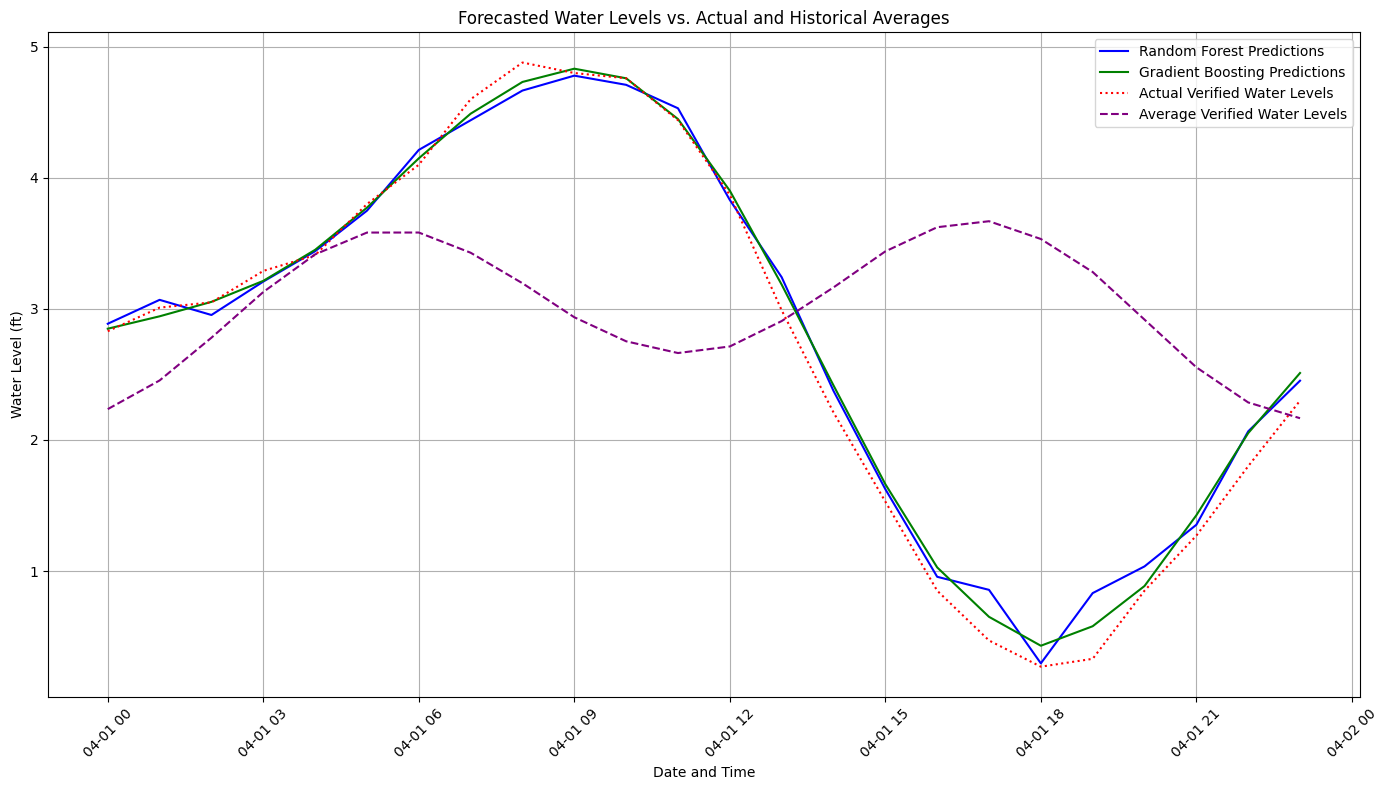

In [15]:
# Get the actual verified water levels and average levels for the prediction times
average_verified_levels = [hourly_averages[hour] for hour in future_data.index.hour]

# Plotting the future predictions along with actual and average verified water levels
plt.figure(figsize=(14, 8))
plt.plot(future_predictions_rf, label='Random Forest Predictions', color='blue')
plt.plot(future_predictions_gbm, label='Gradient Boosting Predictions', color='green')
plt.plot(future_data.index, actual_verified_levels, label='Actual Verified Water Levels', color='red', linestyle='dotted')
plt.plot(future_data.index, average_verified_levels, label='Average Verified Water Levels', color='purple', linestyle='--')
plt.title('Forecasted Water Levels vs. Actual and Historical Averages')
plt.xlabel('Date and Time')
plt.ylabel('Water Level (ft)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate RMSE for Random Forest predictions
rmse_rf = sqrt(mean_squared_error(actual_verified_levels, future_predictions_rf))
print("RMSE for Random Forest predictions:", rmse_rf)

# Calculate RMSE for Gradient Boosting predictions
rmse_gbm = sqrt(mean_squared_error(actual_verified_levels, future_predictions_gbm))
print("RMSE for Gradient Boosting predictions:", rmse_gbm)


RMSE for Random Forest predictions: 0.1791386520733776
RMSE for Gradient Boosting predictions: 0.1346724908633801


In [17]:
# Stop tracking and get emissions data
emissions = tracker.stop()
print(f"Estimated CO2 emissions for the computation: {emissions} kg")

[codecarbon INFO @ 17:20:08] Energy consumed for RAM : 0.000009 kWh. RAM Power : 5.884547710418702 W
[codecarbon INFO @ 17:20:08] Energy consumed for all GPUs : 0.000043 kWh. Total GPU Power : 27.365998987524602 W
[codecarbon INFO @ 17:20:08] Energy consumed for all CPUs : 0.000067 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:20:08] 0.000119 kWh of electricity used since the beginning.


Estimated CO2 emissions for the computation: 4.400938422737497e-05 kg
